# Traffic flow, revisited

As we can remember, on the first codes that I made for this blog was Traffic Flow, which had the following conservaton law

\begin{equation}
\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial x}=0
\end{equation}

where $F$ is the flux, $F=\rho u$. We can remember that a linear relation between the traffic speed and traffic density can be:

\begin{equation}
F(\rho)=\rho u_{max}\left(1-\frac{\rho}{\rho_{max}}\right)
\end{equation}

This flux model meets the two requirements, based on a qualitative view of traffic flow, that:

* $u\rightarrow u_{max}$ and $F\rightarrow 0$ when $\rho=0$
* $u\rightarrow0$ as $\rho\rightarrow \rho_{max}$

However, it leads to some unrealistic or at least improbable results. For example, note that if the traffic speed is a linear function of density, the flux function will be quadratic. In this case, the maximum flux will occur when $\rho^*=\rho_{max}/2$, corresponding to a traffic speed $u_{max}/2$.

A good question to ask here is: should the maximum flux on a given stretch of road have a strict dependence on the maximum speed that the roadway allows, be it by physical restrictions or posted speed limits? In other words, do we really expect the maximum flux to increase if we allow arbitrarily high speeds?

Probably not. but there should be some ideal traffic speed, u^*, corresponding to an ideal traffic density, $\rho^*$, resulting in the maximum traffic flux

\begin{equation}
F_{max}=\rho^*u^*
\end{equation}

Let us improve the initial flux model by taking this observation into account. One thing that we can try is to introduce a flux model that is cubic in $\rho$ instead of quadratic:

\begin{equation}
F(\rho)=u_{max}\rho(1-A\rho-B\rho^2)
\end{equation}

This new model still meets the first criterion listed above: $F\rightarrow 0$ when $\rho\rightarrow 0$. Moreover, we impose the following conditions:

* When $\rho=\rho_{max}$ traffic flux goes to zero:

\begin{equation}
F(\rho_{max})=0=u_{max}\rho_{max}(1-A\rho_{max}-B\rho^2_{max})
\end{equation}

* Based on the equation of $F_{max}$, maximum flux occurs when $\rho=\rho^*$ and $F'(\rho^*)=0$:

\begin{equation}
F'(\rho^*)=0=u_{max}(1-2A\rho^*-3B(\rho^*)^2)
\end{equation}

* We have that $u^*$ is obtained when $\rho=\rho^* $:

\begin{equation}
u^*=u_{max}(1-A\rho^*-B(\rho^*)^2)
\end{equation}

We have three equations and four unknowns $A,B,\rho^*,u^*$. However, in practice, the ideal traffic speed could be obtained for a given road by observations. Similarly to $u_{max}$ and $\rho_{max}$ it will therefore be taken as a parameter.

In [1]:
import numpy as np
import sympy as sympy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import njit, vectorize, float64
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

### Solving the flux equation

I can use SymPy, a library of Python that use LaTex for printing and solving several calculations. I'm gonna use it for discretize my equations. First of all, i'm gonna create *symbols* to use it.

In [2]:
sympy.init_printing()

(u_max,u_star,rho_max,rho_star,A,B)=sympy.symbols('u_max u_star rho_max rho_star A B')

Now I can use *u_max* and the others as a symbols, that means that Python doesn't gonna take it as a variable. Now, we can proceed to create the equations. In this case, these can be created using *sympy.Eq()*

In [3]:
eq1=sympy.Eq(u_max*rho_max*(1-A*rho_max-B*rho_max**2),0)
eq2=sympy.Eq(u_max*(1-2*A*rho_star-3*B*rho_star**2),0)
eq3=sympy.Eq(u_max*(1-A*rho_star-B*rho_star**2),u_star)

It's time to check the inputs to see if we create correctly the equations.

In [4]:
eq1

In [5]:
eq2

In [6]:
eq3

Once we check that the equations are correct, it's time to use it to do some algebraic moves. If we had a value for $u_{star}$ (that it is $u^*$), then i'm only have three unknowns and three equations, so it is possible to solve.

Looking the *eq2* and *eq3*, we see that $A$ and $B$ had a common denominator, so we can elimiate $B$ from *eq2* if we subtract *3eq3*.

This can be made it creatin a new equation and using the parameters *lhs* (Left-Hand Side) and *rhs* (Right-Hand Side). This is

In [7]:
eq4=sympy.Eq(eq2.lhs-3*eq3.lhs,eq2.rhs-3*eq3.rhs)
eq4

This is not exactly what we wanted, but SymPy offers a method to reduce the expression, and that is *simplify()*

In [8]:
eq4.simplify()

We now have an idea of what to do with our three equations. We'll get expressions in term of A from *eq4* and *eq1* and substitute them back into *eq2*. For that, we can use the SympY functions *solve()* and *subs()*. the arguments to *solve()* are the equality that needs to be solved, and the symbol to solve for.

I need to clarify that *solve()* returns the result in a list, as you can get multiple solutions for a given variable. As we have linear equations this will only return one solution so we ask right away for the first term in the list.

In [9]:
rho_sol=sympy.solve(eq4,rho_star)[0]
rho_sol

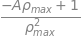

In [10]:
B_sol=sympy.solve(eq1,B)[0]
B_sol

Okey, now we have the solution to *rho_sol* and *B*. We can use now the function *subs()*. This function had the arguments as (old,new) where the new expression substitutes the old one. In this time, if we use *eq2.subs()* we can substitute $\rho_{star}$ with *rho_sol* and substitute $B$ with *B_sol*. 

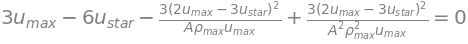

In [11]:
quadA=eq2.subs([(rho_star,rho_sol),(B,B_sol)])
quadA.simplify()

This expression is now a little bit ugly but is quadratic in A, so that means that we can solve for the roots of the equations. Let see the solution

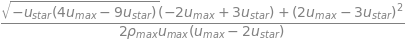

In [12]:
A_sol=sympy.solve(quadA,A)
A_sol[0]

This time, it had two solutions for the equation, so we can see the second one.

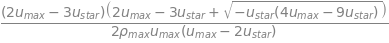

In [13]:
A_sol[1]

It's the same but with some algebraic differences.

### Evaluating the new flux equation.

Quadratic equations, of course, have two solutions. Here we have to select the positive root, otherwise our model would have an inconsistency. Are you able to see why? To determine its value, we need to fill in some actual numbers into the model. 

I'll use the initial values that i use in the first time that I solve this equation using Finite Difference. That values are:

* $\rho_{max}=10$
* $u_{max}=1$
* $u^*=0.7u_{max}$

I propose $u^*=0.7u_{max}$ to solve the equation. This would correspond to 84 km/h for a highway with a 120 km/h speed limit, for example.

Using the expression that we get for *A_sol*, i can use the function *evalf()* to do a numeric substitution. Using the first solution of the list, I get

In [14]:
A_val_0=A_sol[0].evalf(subs={u_max:1, u_star:0.7*u_max, rho_max:10.0})
A_val_0

That a solution for the quadratic equations. But that had two solutions. If we use the second solution of the list $[1]$, let see what values gives us

In [15]:
A_val_1=A_sol[1].evalf(subs={u_max:1, u_star:0.7*u_max, rho_max:10.0})
A_val_1

Well, this is bigger and positive. Since the two values are solution for the quadratic equation, i'm gonna use the second one, so i have $A=0.0146$. Now i can use it to solve $B$.

In [16]:
B_val=B_sol.evalf(subs={rho_max:10,A:A_val_1})
B_val

This is our value for B.

### Turn off LaTex.

LaTex is great for analytical solutions and when we're looking at algebraic expressions, but it's not good for numerical solutions. Now that we had the value of $B$ and $A$, it's a good decision to turn off LaTex.

In [17]:
sympy.init_printing(use_latex=False)

### Solve the equation: Green light.

Now we can solve the equations. Suppose that we have an intersection with a red light in $x=2$. At the stoplight, traffic is bumper-to-bumper, and the traffic density decreases linearly to zero as we approach the beginning of our road. Ahedad of the stoplight, the road is clear. This is the initial condition:

\begin{equation}
\large\rho(x,0)=\left\{ \begin{array}{cc} 
\frac{\rho_{light}x}{2} & 0\leq x<2 \\
        0 &             2\leq x\leq 4 
\end{array}\right.
\end{equation}

The following function calculate that situation.

In [18]:
#@njit
def IC(Nx,Nt,x,rho_light):
    rho=np.zeros((Nx,Nt)) #Create the matrix for the solution
    mask=np.where(x<2)   #Check all the indices where x<2
    #Now, you can put the initial conditions
    rho[mask,0]=(rho_light*x[mask])/2
    return rho

Let see if I do it right. I'm going to create the variables to use and check the initial condition.

In [ ]:
#------------------#
# Variables        #
#------------------#

Nx=201 #Grid points for x
Nt=1001 #Grid points for t
L=12    #Length of the road
tf=12   #Final time
dx=L/(Nx-1)  #Finite step of x
dt=tf/(Nt-1) #Finite step of t
u_max=1 #Maximunm speed allowed on the road
rho_max=10 #Maximum density of cars allowed on the road
rho_light=5 #Car density at the stoplight
A=A_val_1 #The numerical value of A
B=B_val   #The numerical value of B

x=np.linspace(0,L,Nx)  #Array for x
t=np.linspace(0,tf,Nt) #Array for t

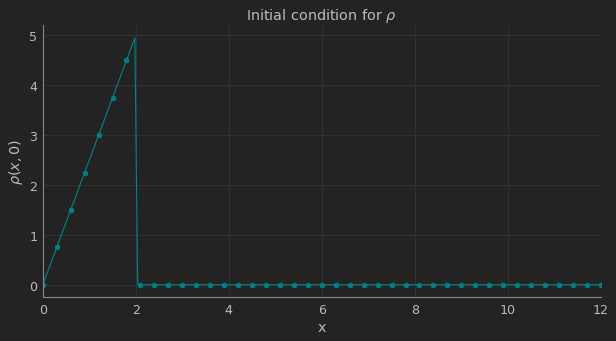

In [29]:
#It's time to check if whe initial conditions are correctly write.
rho=IC(Nx,Nt,x,rho_light)
fig, axs=plt.subplots(1,figsize=(10,5))
axs.set_title('Initial condition for $\\rho$')
axs.plot(x,rho[:,0], color='teal', marker='o',markevery=5)
axs.set_xlabel('x')
axs.set_ylabel('$\\rho(x,0)$')
axs.set_xlim(x[0],x[Nx-1])
axs.set_ylim(rho.min()-0.25,rho.max()+0.25)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

This look good. Now we can solve the PDE. As we remember, the PDE is:

\begin{equation}
\frac{\partial\rho}{\partial t}+\frac{\partial F}{\partial x}=0
\end{equation}

And the discretized equation is:

\begin{equation}
\rho_x^{t+1}=\rho_x^t-\frac{\Delta t}{\Delta x}\left(F(\rho_x^t)-F(\rho_{x-1}^t)\right)
\end{equation}


In [21]:
#@njit()
#This is now the function that calculates the traffic flux.
def F(rho,u_max,A,B):
    return u_max*(rho-A*rho**2-B*rho**3)

#@njit()
#Create a function to put the Boundary Condition of the system
def BC(rho, Nt):
    for j in range(0,Nt-1):
        rho[0,j+1]=rho[0,j]
    return rho

#@njit()
def solution(Nx,Nt,x,rho_light,u_max,A,B,dt,dx):
    rho=IC(Nx,Nt,x,rho_light) #Create the matrix and put the initial condition
    rho=BC(rho,Nt)            #Now, put the boundary condition
    #Now, solve the PDE using Finite Difference
    for j in range(0,Nt-1):
        for i in range(0,Nx):
            rho[i,j+1]=rho[i,j]-(dt/dx)*(F(rho[i,j],u_max,A,B)-F(rho[i-1,j],u_max,A,B))
        rho=BC(rho,Nt) #check that de BC are fullfiled
    return rho

You can check the CFL condition to now if the system is stable or not. In this case, we need:

\begin{equation}
\sigma=max\left[u_{max}\left(1-\frac{2\rho}{\rho_{max}}\frac{\Delta t}{\Delta x}\right)\right]<1
\end{equation}

Let see if the CFL conditions is fullfiled.

In [22]:
def CFL(u_max,rho_max,dt,dx):
    sigma=u_max*(1-(2*rho/rho_max)*(dt/dx))
    print('Our valour sigma is {0:02f}'.format(sigma.max()))

%time rho=solution(Nx,Nt,x,rho_light,u_max,A,B,dt,dx)
CFL(u_max,rho_max,dt,dx)

CPU times: user 9min 9s, sys: 262 ms, total: 9min 9s
Wall time: 9min 10s
Our valour sigma is 1.000000


Okey, the function $\rho$ now can be plotted

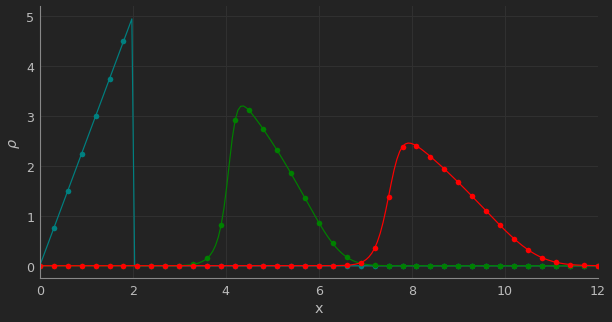

In [28]:
fig,axs=plt.subplots(1,figsize=(10,5))
axs.plot(x,rho[:,0], color='teal', marker='o', markevery=5)
axs.plot(x,rho[:,int((Nt-1)/3)], color='green', marker='o', markevery=5)
axs.plot(x,rho[:,int(2*(Nt-1)/3)], color='red', marker='o', markevery=5)
axs.set_xlim(x[0],x[Nx-1])
axs.set_xlabel('x')
axs.set_ylabel('$\\rho$')
axs.set_ylim(rho.min()-0.25,rho.max()+0.25)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

We can create a animate video to see better how it works.

In [24]:
fig,axs=plt.subplots(1,figsize=(10,5))
line,=axs.plot([],[], color='green', marker='o',markevery=5)
axs.set_xlim(x[0],x[Nx-1])
axs.set_xlabel('x')
axs.set_ylabel('$\\rho$')
axs.set_ylim(rho.min()-0.25,rho.max()+0.25)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
xlabel=np.linspace(0,L,L)
ylabel=np.linspace(rho.min(),rho.max(),5)
axs.set_xticks(xlabel)
axs.set_xticklabels(['{0:.0f} km'.format(xlabel[i]) for i in range(len(xlabel))])
axs.set_yticks(ylabel)
axs.set_yticklabels(['{0:.0f} cars/km'.format(ylabel[i]) for i in range(len(ylabel))])
axs.grid(False)

def animate(i):
    global x,t,rho
    axs.collections.clear()
    line.set_data(x,rho[:,i])
    fill=axs.fill_between(x,rho[:,i],-1, color='green',alpha=0.1)
    axs.set_title('Cars density in t={0:.2f} hours'.format(t[i]))
    return line, fill

anim=FuncAnimation(fig,animate,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Traffic_Flow.mp4',fps=60,extra_args=['-vcodec','libx264'])

CPU times: user 1min 16s, sys: 3.63 s, total: 1min 19s
Wall time: 1min 22s


We can also calculate the Velocity of the system. We can do it with the next equation:

\begin{equation}
u=u_{max}\left(1-\frac{\rho}{\rho_{max}}\right)
\end{equation}

Then, i have

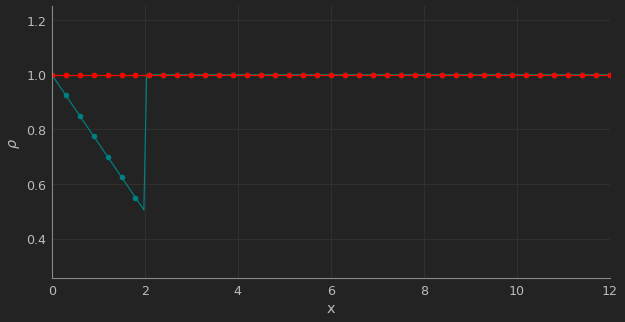

In [35]:
#Function of speed of traffic
def u(rho,u_max,rho_max):
    return u_max*(1-rho/rho_max)

u=u(rho,u_max,rho_max)
#Plot the solution
fig,axs=plt.subplots(1,figsize=(10,5))
axs.plot(x,u[:,0], color='teal', marker='o', markevery=5)
axs.plot(x,u[:,int((Nt-1)/3)], color='green', marker='o', markevery=5)
axs.plot(x,u[:,int(2*(Nt-1)/3)], color='red', marker='o', markevery=5)
axs.set_xlim(x[0],x[Nx-1])
axs.set_xlabel('x')
axs.set_ylabel('$\\rho$')
axs.set_ylim(u.min()-0.25,u.max()+0.25)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

In [32]:
fig,axs=plt.subplots(1,figsize=(10,5))
line,=axs.plot([],[], color='red', marker='o',markevery=5)
axs.set_xlim(x[0],x[Nx-1])
axs.set_xlabel('x')
axs.set_ylabel('$\\rho$')
axs.set_ylim(u.max()-0.25,u.max()+0.25)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
xlabel=np.linspace(0,L,L)
ylabel=np.linspace(u.min(),u.max(),5)
axs.set_xticks(xlabel)
axs.set_xticklabels(['{0:.0f} km'.format(xlabel[i]) for i in range(len(xlabel))])
axs.set_yticks(ylabel)
axs.set_yticklabels(['{0:.0f} km/h'.format(ylabel[i]) for i in range(len(ylabel))])
axs.grid(False)

def animate(i):
    global x,t,u
    axs.collections.clear()
    line.set_data(x,u[:,i])
    fill=axs.fill_between(x,u[:,i],u.max()+0.25, color='red',alpha=0.1)
    axs.set_title('Velocity in t={0:.2f} hours'.format(t[i]))
    return line, fill

anim=FuncAnimation(fig,animate,frames=Nt,interval=60,blit=True)
plt.close()

%time anim.save('Velocity_Flow.mp4',fps=60,extra_args=['-vcodec','libx264'])

CPU times: user 1min 19s, sys: 3.94 s, total: 1min 23s
Wall time: 1min 25s
